# Wines

In [41]:
# import
from IPython.display import display, clear_output
import os
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import random
import time
import matplotlib.pyplot as plt
import itertools

from scipy.spatial.distance import cosine
from nltk.corpus import words
import gensim
from collections import Counter
%matplotlib inline

In [2]:
# utilities
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

years = [str(x) for x in range(1900,2030)]+[str(x) for x in range(0,100)]

def clean_tokenizer(sentence,**kwargs):
    vocab = kwargs.pop('vocab',None)
    stop = stopwords.words('english') + list(string.punctuation) +["'s"]+years
    if vocab:
        return [i for i in word_tokenize(sentence.lower()) if i in vocab and i not in stop]
    else:
        return [i for i in word_tokenize(sentence.lower()) if i not in stop]

In [3]:
# load wine descriptors
wine_descriptors = []
with open("wiki_wine_descriptors.txt","r") as f:
    for line in f:
        wine_descriptors.append(line.lower().strip('\n'))
len(wine_descriptors)

81

In [42]:
wines = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)

## How many wine varieties?

In [5]:
varieties = list(wines['variety'])
varieties.remove(np.nan)
print("There is {} unique wine varieties in this list".format(len(set(varieties))))

There is 707 unique wine varieties in this list


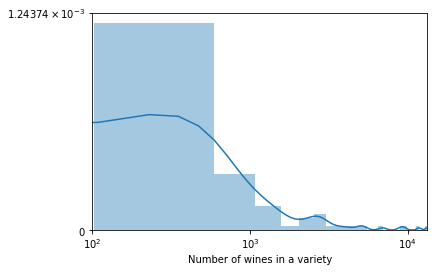

In [6]:
variety_cnt = Counter()
for variety in wines['variety']:
    variety_cnt[variety] += 1

variety_cnt
sorted_varieties = dict(sorted(variety_cnt.items(), key=lambda x: x[1]))
values = [x for x in variety_cnt.values()]
sns.distplot([value for value in values if value>100])#,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlim([100, max(values)])
# plt.ylim([0.8, 1])
plt.xlabel('Fraction of varieties  of wines in a variety')
plt.xlabel('Number of wines in a variety')

In [7]:
n_items_thresh = 500
vals_above_thresh = [value for value in values if value >n_items_thresh]

print("There are {} varieties of wines with more than {} entries in the DB. Total is {}".format(
    len(vals_above_thresh),
    n_items_thresh,
    sum(vals_above_thresh)
     ))

There are 40 varieties of wines with more than 500 entries in the DB. Total is 111797


In [8]:
top_varieties = {k:v for k,v in dict(variety_cnt).items() if v>n_items_thresh}
top_varieties

{'Barbera': 721,
 'Bordeaux-style Red Blend': 6915,
 'Bordeaux-style White Blend': 1066,
 'Cabernet Franc': 1353,
 'Cabernet Sauvignon': 9472,
 'Carmenère': 575,
 'Champagne Blend': 1396,
 'Chardonnay': 11753,
 'Chenin Blanc': 591,
 'Corvina, Rondinella, Molinara': 619,
 'Gamay': 1025,
 'Gewürztraminer': 1012,
 'Glera': 709,
 'Grenache': 651,
 'Grüner Veltliner': 1345,
 'Malbec': 2652,
 'Merlot': 3102,
 'Nebbiolo': 2804,
 'Petite Sirah': 770,
 'Pinot Grigio': 1052,
 'Pinot Gris': 1455,
 'Pinot Noir': 13272,
 'Port': 668,
 'Portuguese Red': 2466,
 'Portuguese White': 1159,
 'Red Blend': 8946,
 'Rhône-style Red Blend': 1471,
 'Riesling': 5189,
 'Rosé': 3564,
 'Sangiovese': 2707,
 'Sangiovese Grosso': 751,
 'Sauvignon Blanc': 4967,
 'Shiraz': 836,
 'Sparkling Blend': 2153,
 'Syrah': 4142,
 'Tempranillo': 1810,
 'Tempranillo Blend': 588,
 'Viognier': 996,
 'White Blend': 2360,
 'Zinfandel': 2714}

In [9]:
clean_tokenizer(wines.sample(n=1)['description'].values[0].lower())

['little',
 'sharp',
 'green',
 'give',
 'fatty',
 'steak',
 'ribs',
 'fine',
 'needs',
 'protein',
 'wake',
 'blackberry',
 'cherry',
 'sweetness']

In [10]:
corpus = dict.fromkeys(varieties,[])
for variety in top_varieties:
    print(variety)
    wines[wines['variety']==variety].apply(lambda x: corpus[variety].append(clean_tokenizer(x["description"])),axis = 1)

White Blend
Portuguese Red
Pinot Gris
Riesling
Pinot Noir
Gewürztraminer
Cabernet Sauvignon
Chardonnay
Malbec
Tempranillo Blend
Red Blend
Merlot
Chenin Blanc
Gamay
Sauvignon Blanc
Bordeaux-style White Blend
Sangiovese
Cabernet Franc
Champagne Blend
Bordeaux-style Red Blend
Petite Sirah
Carmenère
Rosé
Zinfandel
Grüner Veltliner
Viognier
Syrah
Nebbiolo
Barbera
Rhône-style Red Blend
Portuguese White
Sangiovese Grosso
Shiraz
Grenache
Sparkling Blend
Pinot Grigio
Tempranillo
Glera
Corvina, Rondinella, Molinara
Port


In [11]:
pooled_descs = []
[pooled_descs.extend(corpus[variety]) for variety in top_varieties]
print("'pooled_desc' contains {} descriptions from the top varieties".format(len(pooled_descs)))


'pooled_desc' contains 4471880 descriptions from the top varieties


In [12]:
vec_size = 80
model = gensim.models.Word2Vec(
        pooled_descs,
        size=vec_size,
        window=6,
        min_count=9,
        workers=8)
model.train(pooled_descs, total_examples=len(pooled_descs), epochs=10)
# full vocabulary
vocab = list(model.wv.vocab.keys())

In [16]:
word = 'gamay'#random.choice(wine_descriptors)
print(word)
model.wv.most_similar(word,topn=10)

gamay


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('southwest', 0.5302480459213257),
 ('sancerre', 0.5065856575965881),
 ('castelão', 0.5005534887313843),
 ('aragonez', 0.4958513379096985),
 ('touraine', 0.49463576078414917),
 ('cahors', 0.49184635281562805),
 ('braucol', 0.4843861162662506),
 ('entre-deux-mers', 0.4777679443359375),
 ('volnay', 0.4765344262123108),
 ('chablis', 0.4668514132499695)]

In [40]:
wine_desc = wines.sample(n=1)['description'].values[0]
print(wine_desc)
# clean_desc = [x for x in clean_tokenizer(wine['description'].values[0]) if x in vocab]
print(get_sum_vec_from_desc(wine_desc,vocab))
model.most_similar(positive=[get_sum_vec_from_desc(wine_desc,vocab)])

This opens with toasted oak, pressed wild flower and hay aromas. The lean, diluted palate offers butterscotch and tart lemon zest flavors. Although the acidity is brisk, it lacks fruit richness.
[-2.94082165e-01 -5.60464973e+01 -1.45262825e+00 -1.73942108e+01
  1.22857437e+01  1.72421207e+01 -3.99139557e+01  2.71849689e+01
 -7.74311686e+00  8.35616016e+00 -1.00613441e+01 -8.89113712e+00
  8.29856396e+00 -1.63014851e+01 -1.59812584e+01 -2.73051243e+01
  2.99537029e+01 -2.57652397e+01 -1.13695965e+01 -5.53888702e+01
 -1.92564754e+01  1.68988628e+01  4.68231058e+00 -4.89358292e+01
 -2.69409904e+01  4.44895020e+01  2.08786430e+01 -8.28593063e+01
 -1.14602718e+01  5.40003052e+01  6.69587708e+01  1.70951443e+01
 -1.81608524e+01  1.92768822e+01 -1.65004206e+00 -1.93588066e+01
  6.61902332e+00  3.07023907e+01 -5.86293678e+01  1.63976021e+01
 -5.52686214e+00 -2.01167412e+01 -6.10869217e+00  4.42817116e+00
 -2.01548042e+01  1.82167702e+01 -5.20419931e+00 -2.99713993e+01
  1.61350765e+01  1.18772

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('flower', 0.5820857286453247),
 ('hay', 0.5360601544380188),
 ('hazelnut', 0.5353198647499084),
 ('sensations', 0.5177141427993774),
 ('diluted', 0.515918493270874),
 ('subdued', 0.5122856497764587),
 ('palate', 0.5104039311408997),
 ('carry', 0.4997809827327728),
 ('camphor', 0.4944264590740204),
 ('wildflower', 0.4904298186302185)]

In [ ]:
def descriptions_similarity(desc1,desc2,**kwargs):
    vocab = kwargs.pop('vocab',None)
    if vocab:
        desc1 = list(set(desc1).intersection(vocab))
        desc2 = list(set(desc2).intersection(vocab))
    mean_vec1 = np.mean(model.wv[desc1],axis=0)
    mean_vec2 = np.mean(model.wv[desc2],axis=0)
    return cosine(mean_vec1, mean_vec2)

In [26]:
def get_mean_vec_from_desc(desc1,vocab):
    desc1 = list(set(clean_tokenizer(desc1)).intersection(vocab))
    return np.mean(model.wv[desc1],axis=0)

def get_sum_vec_from_desc(desc1,vocab):
    desc1 = list(set(clean_tokenizer(desc1)).intersection(vocab))
    return np.sum(model.wv[desc1],axis=0)

In [19]:
get_vec_from_desc(wines.sample(n=1)['description'].values[0],vocab)

array([ 7.4255908e-01, -6.7447525e-01,  4.3824881e-01, -1.5753216e+00,
        9.7110641e-01, -6.6371685e-01, -1.1124542e+00, -1.1458507e+00,
        4.3104401e-01, -8.4347337e-01,  4.1984591e-01, -1.6677872e-03,
        1.1446494e+00, -7.0013511e-01, -4.2652884e-01, -1.7681513e+00,
        1.0094731e+00,  9.6752447e-01,  8.5671866e-01, -1.2432399e+00,
       -2.1970728e-01,  1.2279481e+00, -2.4169913e-01,  3.9777160e-01,
       -6.4005840e-01, -7.2335768e-01,  3.4455556e-01, -1.5039772e+00,
       -1.0220701e+00,  1.2937248e+00,  2.3823302e+00,  2.1789715e-01,
       -7.9702055e-01, -6.1601764e-01, -3.3324748e-01,  8.8962816e-02,
        1.7455890e+00,  3.4582523e-01, -3.5015002e-01,  3.4640771e-01,
       -7.2422349e-01,  1.8049160e+00, -1.4210504e-01,  3.9166111e-01,
       -3.3659661e-01,  7.3540084e-02, -7.4349827e-01, -4.3122867e-01,
        1.7135633e+00, -1.7055099e-01,  6.0302973e-01,  1.5474998e+00,
       -2.5902635e-01, -1.5172492e+00, -4.2691761e-01,  1.1775168e+00,
      

In [130]:
def get_mean_variety_vec(corpus,variety,vocab):
    if variety in list(corpus.keys()):
        pooled_desc = itertools.chain.from_iterable(corpus[variety])
        return np.mean(model.wv[pooled_desc],axis=0)
    else:
        raise ValueError("unknown variety")
            

In [49]:
variety = "Glera"  #"Port

wine_1 = wines[wines['variety']==variety].sample(n=1)
wine_1


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
122157,Italy,Simple tones of white fruit and crushed stone ...,Brut,86,18.0,Veneto,Asolo Prosecco Superiore,NaN,NaN,NaN,Case Paolin NV Brut (Asolo Prosecco Superiore),Glera,Case Paolin


In [51]:
wine_2 = wines[wines['variety']==variety].sample(n=1)
wine_2

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
61669,Italy,Aromas of jasmine and white orchard fruit lead...,Brut,87,17.0,Veneto,Conegliano Valdobbiadene Prosecco Superiore,NaN,Kerin O’Keefe,@kerinokeefe,Raphael Dal Bo NV Brut (Conegliano Valdobbiad...,Glera,Raphael Dal Bo


In [58]:
vec_1 = get_sum_vec_from_desc(wine_1['description'].values[0],vocab)
vec_1
model.similar_by_vector(vec_1)

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tones', 0.5776785612106323),
 ('white', 0.5552210211753845),
 ('effervescence', 0.5428985953330994),
 ('tonic', 0.5314098000526428),
 ('superiore', 0.5043275952339172),
 ('perlage', 0.49291616678237915),
 ('cheerful', 0.48253685235977173),
 ('sparkler', 0.4783901274204254),
 ('foam', 0.4763756990432739),
 ('almond', 0.4659837484359741)]

In [49]:
for idx, wine in wines.sample(n=10).iterrows():
    print(wine['title'],"-/--",wine['variety'])

Robert Weil 2011 Kiedrich Gräfenberg Erstes Gewächs Trocken Riesling (Rheingau) -/-- Riesling
Domaine Gavoty 2014 Cuvée Tradition Rosé (Côtes de Provence) -/-- Rosé
Adriano Marco & Vittorio 2011  Moscato d'Asti -/-- Moscato
Rosemont 2011 Syrah (Virginia) -/-- Syrah
Aveleda NV Casal Garcia Medium Dry Sparkling (Vinho Verde) -/-- Portuguese Sparkling
Château la Marzelle 2014  Saint-Émilion -/-- Bordeaux-style Red Blend
Three Rivers 2013 Malbec-Merlot (Columbia Valley (WA)) -/-- Malbec-Merlot
Hamlet 2012 Pinot Gris (Virginia) -/-- Pinot Gris
Gérard Bertrand 2014 Château La Sauvageonne GMVV Rosé (Coteaux du Languedoc) -/-- Rosé
Testarossa 2009 Garys' Vineyard Syrah (Santa Lucia Highlands) -/-- Syrah


In [ ]:
variety_feat_mat = np.empty([vec_size, len(top_varieties)])
for idx, variety in enumerate(top_varieties):
    variety_feat_mat[:,idx] = get_mean_variety_vec(corpus,variety,vocab)
#     print(mean_variety_vec.shape)
#     variety_feat_mat = np.concatenate((variety_feat_mat, mean_variety_vec), axis=1)

In [20]:
model.wv['acid']

array([ 0.7251488 , -2.5317702 , -1.9163985 ,  4.0889997 ,  3.8206613 ,
       -1.4792136 , -5.589569  , -3.8782206 , -1.7768035 ,  2.5695996 ,
        0.72781545,  2.0208828 , -1.671599  , -4.135302  ,  0.95505404,
       -5.904454  ,  1.3468721 , -1.5988615 ,  6.5539546 ,  0.01805219,
       -1.4194012 ,  1.926158  ,  2.7366133 , -1.7378643 ,  2.5590408 ,
        1.8827958 ,  3.3593783 , -3.102206  , -1.734364  ,  1.7118086 ,
        0.7918724 , -0.60808367,  3.2343788 ,  3.4260652 ,  1.6703877 ,
       -0.821487  ,  4.73939   , -0.36875728,  3.4355805 , -1.299591  ,
       -5.047547  ,  0.08424437,  0.42921612, -2.2511663 , -5.626322  ,
       -0.57558525,  6.667234  , -4.0419173 ,  2.5485682 , -0.8304031 ,
       -3.8161948 ,  2.3767161 ,  1.569417  , -1.6394805 ,  6.7740526 ,
        4.0599084 ,  5.3935957 , -3.0815043 ,  2.7535233 , -2.2571151 ,
       -4.596458  , -1.1683162 , -6.1627836 , -0.30625075,  1.820235  ,
       -5.5278277 , -2.441061  , -6.6247087 , -1.5127312 ,  0.60

In [22]:
wines.sample(n=1)['description'].values[0]

'Minty oaky aromas of baking spices share space on the nose with earthy black plum and berry notes. This feels tannic and resiny while the oaky spicy berry flavors finish with force and drying tannins.'

In [74]:
# pick random wine
this_wine = wines.sample(n=1)
prin(this_wine['variety'].values[0])




array(['Pinot Noir'], dtype=object)

In [75]:
variety_feat_mat.shape

(80, 128)

In [76]:
feat_vect = get_vec_from_desc(wines.sample(n=1)['description'].values[0],vocab)
feat_vect.shape

(80,)

In [82]:
cosines_to_varieties = [cosine(feat_vect,x) for x in ]/np.linalg.norm(feat_vect)

cosine_closest = np.array([(feat_vect,variety_feat_mat[:,0])/np.linalg.norm(feat_vect) for feat_vect in ])

In [125]:
cosine_to_varieties = np.empty([len(top_varieties),1])
for index in range(0,variety_feat_mat.shape[1]-1):
    x =  variety_feat_mat[:,index]
    cosine_to_varieties[index] = cosine(x,feat_vect)#/np.linalg.norm(feat_vect)


In [126]:
cosine_to_varieties

array([[1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.548

In [127]:
variety_feat_mat[:,0]

array([ 0.11044145, -0.07531391,  0.07324275, -0.01208648,  0.29134712,
       -0.00666942,  0.09475937, -0.25099552,  0.27502015,  0.05638684,
       -0.04598946,  0.20567501,  0.19647652,  0.03817679, -0.00665   ,
        0.1599315 , -0.07453687, -0.30949321,  0.04190506, -0.21889822,
        0.21222253, -0.27521598,  0.18922079,  0.5024814 ,  0.19261868,
        0.15738899,  0.06505712,  0.34035936,  0.05964699,  0.0788378 ,
        0.19690418,  0.07246489, -0.07701673,  0.45772335, -0.03854014,
        0.16730706, -0.09149095,  0.04378865, -0.09555584, -0.23299222,
       -0.00956781, -0.19048984,  0.2147489 ,  0.06496047,  0.07217062,
       -0.17329443,  0.0206799 ,  0.17356676, -0.19051684,  0.22575979,
       -0.06652635, -0.2836675 , -0.1738915 , -0.49212253,  0.13728528,
        0.25923604, -0.0082758 ,  0.00224301, -0.0121464 , -0.38505086,
        0.06126573, -0.45131955, -0.23558451, -0.28431478, -0.04035823,
        0.550915  , -0.03473023,  0.36679521, -0.12635785, -0.27

In [128]:
variety_feat_mat[:,1]

array([ 0.11044145, -0.07531391,  0.07324275, -0.01208648,  0.29134712,
       -0.00666942,  0.09475937, -0.25099552,  0.27502015,  0.05638684,
       -0.04598946,  0.20567501,  0.19647652,  0.03817679, -0.00665   ,
        0.1599315 , -0.07453687, -0.30949321,  0.04190506, -0.21889822,
        0.21222253, -0.27521598,  0.18922079,  0.5024814 ,  0.19261868,
        0.15738899,  0.06505712,  0.34035936,  0.05964699,  0.0788378 ,
        0.19690418,  0.07246489, -0.07701673,  0.45772335, -0.03854014,
        0.16730706, -0.09149095,  0.04378865, -0.09555584, -0.23299222,
       -0.00956781, -0.19048984,  0.2147489 ,  0.06496047,  0.07217062,
       -0.17329443,  0.0206799 ,  0.17356676, -0.19051684,  0.22575979,
       -0.06652635, -0.2836675 , -0.1738915 , -0.49212253,  0.13728528,
        0.25923604, -0.0082758 ,  0.00224301, -0.0121464 , -0.38505086,
        0.06126573, -0.45131955, -0.23558451, -0.28431478, -0.04035823,
        0.550915  , -0.03473023,  0.36679521, -0.12635785, -0.27

In [134]:
desc = wines.sample(n=1)['description'].values[0]
feat_vect = get_vec_from_desc(desc,vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [138]:
feat_vect = get_vec_from_desc(desc,vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [156]:
token_list = clean_tokenizer(desc)
random.shuffle(token_list)
feat_vect = get_vec_from_desc(" ".join(token_list),vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [148]:
random.shuffle([1,3,45,45,45,4,5random.sample(x, len(x))

In [160]:
variety_feat_mat[0]

array([0.00000000e+000, 1.25767710e-076, 0.00000000e+000, 3.85464794e-057,
       1.25767909e-076, 8.97917664e-067, 1.83153583e-076, 1.25771476e-076,
       6.00893663e-067, 1.51898041e-047, 1.25767446e-076, 6.82016317e-038,
       5.63863945e-062, 6.96324176e-077, 8.98354613e-067, 5.34618094e-038,
       1.81149296e-152, 1.42759683e-071, 8.54289848e-072, 1.58116940e-153,
       5.94082931e-038, 1.30355142e-076, 1.65662909e-153, 4.85260286e-033,
       1.30355142e-076, 1.39638544e+136, 8.97190379e-067, 6.96323520e-077,
       1.83255844e-076, 3.24263858e-086, 2.10816434e-052, 5.15722155e-062,
       3.24245682e-086, 2.42178677e-052, 1.57110400e-076, 3.24245691e-086,
       6.38563587e-067, 1.51818066e-047, 6.12743499e-154, 4.08598376e-033,
       1.89812469e-052, 6.03981071e-154, 1.57077328e-076, 1.68931486e-052,
       2.48583955e-091, 4.66527025e-033, 1.57009187e-076, 4.07628811e+223,
       3.54039294e-057, 3.24245684e-086, 4.47042615e-033, 1.51818066e-047,
       3.24245662e-086, 1

In [25]:
[x for x in clean_tokenizer(wines.sample(n=1)['description'].values[0]) if x in vocab]

['nice',
 'little',
 'red',
 'blend',
 'easy',
 'drink',
 'cheerful',
 'flavors',
 'blackberries',
 'cherries',
 'ripe',
 'without',
 'face',
 'entirely',
 'dry',
 'light',
 'tannins',
 'enjoy',
 'everything',
 'sandwiches',
 'steak']

['White Blend',
 'Portuguese Red',
 'Pinot Gris',
 'Riesling',
 'Pinot Noir',
 'Tempranillo-Merlot',
 'Frappato',
 'Gewürztraminer',
 'Gewürztraminer',
 'Pinot Gris',
 'Cabernet Sauvignon',
 'Gewürztraminer',
 'Cabernet Sauvignon',
 'Nerello Mascalese',
 'Chardonnay',
 'Riesling',
 'Malbec',
 'Malbec',
 'Tempranillo Blend',
 'Meritage',
 'Red Blend',
 'Pinot Noir',
 'White Blend',
 'Merlot',
 "Nero d'Avola",
 'Pinot Noir',
 'White Blend',
 "Nero d'Avola",
 'Red Blend',
 'Chenin Blanc',
 'Gamay',
 'Red Blend',
 'White Blend',
 'Red Blend',
 'Sauvignon Blanc',
 'Pinot Noir',
 'Viognier-Chardonnay',
 'Cabernet Sauvignon',
 'Primitivo',
 "Nero d'Avola",
 'Catarratto',
 'Pinot Noir',
 'Gamay',
 'Sauvignon Blanc',
 'Merlot',
 'Red Blend',
 'Inzolia',
 'Riesling',
 'Sauvignon Blanc',
 'Gamay',
 'Red Blend',
 'Petit Verdot',
 'Monica',
 'Bordeaux-style White Blend',
 'Red Blend',
 'Chardonnay',
 'Chardonnay',
 'Grillo',
 'Pinot Noir',
 'Malbec',
 'Cabernet Sauvignon',
 'Sangiovese',
 'Cabernet

In [44]:
model.most_similar(positive=['chardonnay'])

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('chard', 0.8095741271972656),
 ('blanc', 0.6153700351715088),
 ('chardonnays', 0.6071824431419373),
 ('gewürz', 0.5741649270057678),
 ('riesling', 0.530490517616272),
 ('chards', 0.5127464532852173),
 ('viognier', 0.5119463801383972),
 ('bubbly', 0.5010278224945068),
 ('sémillon', 0.49409496784210205),
 ('champagne', 0.4821004867553711)]

# Doc2Vec Attempt


In [59]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [134]:
# data = ["I love machine learning. Its awesome.",
#         "I love building chatbots",        
#         "I love coding in python",
#         "they chat amagingly well"]

sub_df = wines.sample(n=1000)
[clean_tokenizer(item['description']) for (_,item) in sub_df.iterrows()]

[['harrison',
  'hill',
  'vineyard',
  'washington',
  'oldest',
  'cabernet',
  'vines',
  'blend',
  'cabernet',
  'sauvignon',
  'merlot',
  'cabernet',
  'franc',
  'petit',
  'verdot',
  'offers',
  'distinctive',
  'flavor',
  'profile',
  'clean',
  'sharp',
  'herbal',
  'interesting',
  'earthy',
  'note',
  'flavors',
  'mingle',
  'beautifully',
  'carry',
  'tart',
  'tight-knit',
  'red',
  'fruit',
  'polished',
  'lightly',
  'slatey',
  'tannins',
  'chewy',
  'lightly',
  'peppery',
  'finish'],
 ['blend',
  'premier',
  'grand',
  'cru',
  'pinot',
  'noir',
  'chardonnay',
  'vintages',
  'difficult',
  'harvest',
  'rare',
  'wine',
  'soft',
  'texture',
  'smooth',
  'fruit',
  'exception',
  'already',
  'mature',
  'offers',
  'hints',
  'almonds',
  'well',
  'ripe',
  'fruits',
  'ready',
  'drink',
  'rich',
  'middle',
  'crisp',
  'end'],
 ['ripe',
  'berries',
  'violets',
  'scent',
  'heady',
  'perfumed',
  'riesling',
  'palate',
  'rich',
  'confecti

In [156]:
tagged_data = [TaggedDocument(words=clean_tokenizer(_item['description']), tags=[_item.index[0]]) for i, _item in sub_df.iterrows()]

In [137]:
# tagged_data

[TaggedDocument(words=['harrison', 'hill', 'vineyard', 'washington', 'oldest', 'cabernet', 'vines', 'blend', 'cabernet', 'sauvignon', 'merlot', 'cabernet', 'franc', 'petit', 'verdot', 'offers', 'distinctive', 'flavor', 'profile', 'clean', 'sharp', 'herbal', 'interesting', 'earthy', 'note', 'flavors', 'mingle', 'beautifully', 'carry', 'tart', 'tight-knit', 'red', 'fruit', 'polished', 'lightly', 'slatey', 'tannins', 'chewy', 'lightly', 'peppery', 'finish'], tags=['65861']),
 TaggedDocument(words=['blend', 'premier', 'grand', 'cru', 'pinot', 'noir', 'chardonnay', 'vintages', 'difficult', 'harvest', 'rare', 'wine', 'soft', 'texture', 'smooth', 'fruit', 'exception', 'already', 'mature', 'offers', 'hints', 'almonds', 'well', 'ripe', 'fruits', 'ready', 'drink', 'rich', 'middle', 'crisp', 'end'], tags=['84337']),
 TaggedDocument(words=['ripe', 'berries', 'violets', 'scent', 'heady', 'perfumed', 'riesling', 'palate', 'rich', 'confectionery', 'style', 'candied', 'cherry', 'honey', 'notes', 'ling

In [157]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    clear_output(wait=True)
    display('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha


'iteration 99'

In [ ]:
this_wine = wines.sample(n=1)

In [163]:
new_desc = clean_tokenizer(this_wine['description'].values[0],vocab=list(model.wv.vocab.keys()))
print(new_desc)
v1 = model.infer_vector(new_desc)#,epochs=10)
print("V1_infer", v1)

['named', 'chalky', 'land', 'grapes', 'wine', 'grown', 'ripe', 'wine', 'also', 'tight', 'mineral', 'texture', 'comes', 'crisp', 'edge', 'packed', 'acidity', 'winemaker', 'made', 'almost', 'rosé', 'age', 'certainly', 'better', 'end']
V1_infer [ 0.04790955 -0.00024995 -0.03474944  0.05704563  0.08810263 -0.03100309
 -0.13966024  0.07061198 -0.03165708  0.14813584 -0.00299267  0.15623306
 -0.03976908 -0.04287127 -0.00864895 -0.03677969  0.02278905  0.00645535
  0.01848435  0.00520137]


In [164]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1])
print(similar_doc)


# # to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
# print(model.docvecs['1'])

[('country', 0.2944878339767456)]


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [151]:
wines.loc[43892]['description']

'Barolo Bricco Rocca boasts its own personality that puts more focus on broader, horizontal aromas of Graham cracker, dried grass and spice rather than vertical notes of cola and mint. Because of its unique traits, this wine would pair with stewed meats or baked white beans.'

In [153]:
this_wine['description'].values[0]

"Starts off with decent aromas of black cherries, dried herbs, coffee and vanilla, then adds a touch of something akin to maple syrup on the palate. Even for a Barossa Cabernet, it's atypically plump and round, with soft acids and almost a hint of sweetness on the finish."

In [155]:
this_wine.index[0]

75425